IMPORTING LIBRARIES

###Steps to connect to kaggle

In [1]:
!pip install kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "*****" # username from the kaggle.json file downloaded from kaggle
os.environ['KAGGLE_KEY'] = "*************************" # key from the kaggle.json file downloaded from kaggle

###Download train.csv and test.csv

In [3]:
!kaggle competitions download -c digit-recognizer

 89% 65.0M/73.2M [00:00<00:00, 77.4MB/s]
100% 73.2M/73.2M [00:00<00:00, 107MB/s] 
 88% 43.0M/48.8M [00:00<00:00, 45.1MB/s]
100% 48.8M/48.8M [00:00<00:00, 110MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 61.6MB/s]


###Importing libraries

In [4]:
import pandas as pd # for pandas data frame operations
import numpy as np # to work on numerical arrays
import seaborn as sns # seabonrn for visualization
import matplotlib.pyplot as plt # plots for visualization
import matplotlib.image as mpimg # to load image data
from sklearn.model_selection import train_test_split # to split train.csv data for cross validation
from sklearn.metrics import confusion_matrix # to construct confusion matrix
import itertools # has iterator functions for efficient looping
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to construct in CNN
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # Operations on CNN
from keras.optimizers import RMSprop # RMSProp optimizer
from keras.preprocessing.image import ImageDataGenerator # Image generator class
from keras.callbacks import ReduceLROnPlateau # Reduce learning rate callback function

Using TensorFlow backend.


###Setting environment for visulaization

In [0]:
%matplotlib inline
sns.set()

###Loading the data set

In [6]:
# Load the data (images stored as pixel values)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape

(42000, 785)

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

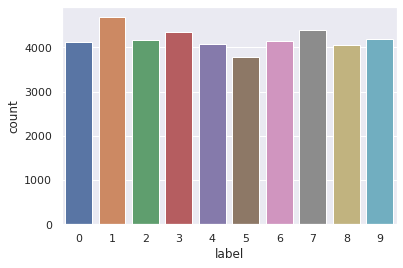

In [7]:
Y = train["label"] # target of train.csv data
X = train.drop(labels = ["label"],axis = 1) # Drop 'label' column from train.csv data
g = sns.countplot(Y) # display the distribution of digits in train.csv data
Y.value_counts().sort_values() # count the distribution of digits in train.csv data

In [0]:
del train # delete train dataframe to free some space 

###Preprocessing

In [9]:
#Check for null and missing values in train.csv data
X.isnull().any().describe() # the result shows there is no null values

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
#Check for null and missing values in test.csv data
test.isnull().any().describe() # the result shows there is no null values

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
X = X / 255.0 # Normalize train.csv data
test = test / 255.0 # Normalize test.csv the data

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [13]:
X.shape #reshaped from "42000 X 784" to "42000 X 28 X 28 X 1"

(42000, 28, 28, 1)

In [0]:
Y = to_categorical(Y, num_classes = 10) # one hot encoding (example: 2 -> [0,0,1,0,0,0,0,0,0,0])

In [15]:
Y # display the encoded target column

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, shuffle=True) # Split the train and the validation set for cross validation

In [17]:
# dimensions of the cross validation data
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(33600, 10)
(8400, 10)


###Display sample images from numpy array

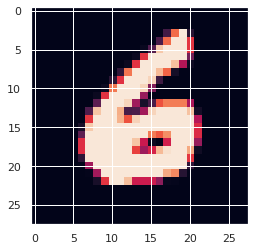

In [18]:
g = plt.imshow(X_train[0][:,:,0]) # first image

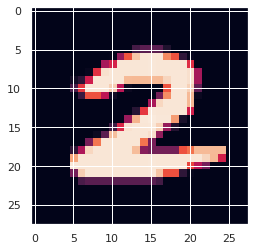

In [19]:
g = plt.imshow(X_train[1][:,:,0]) # second image

#Constructing the Convolutional Neural Network (CNN)
#### [Conv2D(relu) -> Conv2D(relu) -> MaxPool2D -> Dropout] -> [Conv2D(relu) -> Conv2D(relu) -> MaxPool2D -> Dropout] ->
####-> Flatten -> Dense -> Dropout -> Out

In [20]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu',
                 input_shape = (28,28,1))) # input 2D convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # 2D max pooling
model.add(Dropout(0.25)) # applies dropout to prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Flattens without affecting the size
model.add(Dense(256, activation = "relu")) # dense layer of size 256 units
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) # dense layer of size 10 to output the digit value






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # RMSprop optimizer divides the gradient by root mean square
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) # Compile the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            factor=0.3, 
                                            verbose=1, 
                                            min_lr=0.00001) # reduces learning rate if the learning is stagnant

In [0]:
# Generate batches of tensor image data with real-time data augmentation
# The data will be looped over (in batches).
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # zoom image
        width_shift_range=0.1,  # shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # shift images vertically (fraction of total height)
        horizontal_flip=False,  # flip images horizontally
        vertical_flip=False)  # flip images vertically
datagen.fit(X_train) # apply datagen augmentation to train.csv data

In [34]:
# Fit the model
epochs = 10
batch_size = 84
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





 - 248s - loss: 0.4459 - acc: 0.8608 - val_loss: 0.0856 - val_acc: 0.9730
Epoch 2/10
 - 242s - loss: 0.1707 - acc: 0.9497 - val_loss: 0.0550 - val_acc: 0.9856
Epoch 3/10
 - 237s - loss: 0.1257 - acc: 0.9651 - val_loss: 0.0469 - val_acc: 0.9868
Epoch 4/10
 - 236s - loss: 0.1132 - acc: 0.9691 - val_loss: 0.0389 - val_acc: 0.9899
Epoch 5/10
 - 234s - loss: 0.1096 - acc: 0.9702 - val_loss: 0.0550 - val_acc: 0.9858
Epoch 6/10
 - 235s - loss: 0.1066 - acc: 0.9718 - val_loss: 0.0361 - val_acc: 0.9895
Epoch 7/10
 - 236s - loss: 0.1061 - acc: 0.9728 - val_loss: 0.0374 - val_acc: 0.9895

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 8/10
 - 235s - loss: 0.0653 - acc: 0.9815 - val_loss: 0.0278 - val_acc: 0.9925
Epoch 9/10
 - 241s - loss: 0.0589 - acc: 0.9835 - val_loss: 0.0270 - val_acc: 0.9936
Epoch 10/10
 - 240s - loss: 0.0593 - acc: 0.9827 - v

###Visualizing the model **loss** and **accuracy**

In [35]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


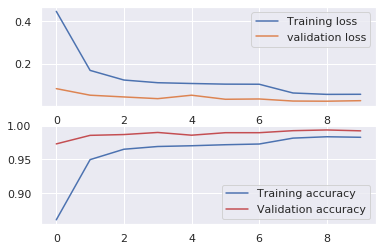

In [44]:
fig, ax = plt.subplots(2,1) # aligning two plots horizontally
ax[0].plot(history.history['loss'], label="Training loss") 
ax[0].plot(history.history['val_loss'],label="validation loss")
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best')

###Making predictions on test.csv data

In [0]:
results = model.predict(test) # predicting test.csv data
results = np.argmax(results,axis = 1) # select the index with maximum probability
results = pd.Series(results,name="Label")

In [62]:
test.shape # no. of rows in test.csv data

(28000, 28, 28, 1)

In [64]:
# creating submission file
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1) 
submission.to_csv("digit_recongizer_using_cnn.csv",index=False)
print('csv file ready for submission')

csv file ready for submission
